In [1]:
# This notebook is a study into the utility of autoencoders for RL agents

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gym
from gym import wrappers

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
cartpole = gym.make("CartPole-v1")
cartpole = wrappers.Monitor(cartpole, ".", video_callable=False ,force=True)

/home/luke/anaconda3/envs/autoencoders/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def get_screen(env):
    # Grab the grb screen values
    rend = env.render(mode='rgb_array')
    
    # Convert to grayscale
    gray = rgb2gray(rend)
    
    # Downsample 4x
    d_gray = gray[::4,::4]
    
    return d_gray
    
def plt_screen(screen):
    plt.imshow(screen, cmap = plt.get_cmap('gray'))
    

In [5]:
class ScreenBuffer:
    
    def __init__(self):
        self.memory = list()
        
    def __len__(self):
        return len(self.memory)
    
    def add(self, frame):
        self.memory.append(frame) 
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [6]:
# Network   
CODE_SIZE = 4 # Each state variable in cartpole
INPUT_SIZE = np.prod(np.array([100, 150]))
class VariationalAutoEncoder(nn.Module):                                                             
    def __init__(self):                                                                   
        super(VariationalAutoEncoder, self).__init__()                                               
                                                     
        self.fc1 = nn.Linear(INPUT_SIZE, 256)                                                  
        self.fc2 = nn.Linear(256, 64)                                                    
        self.fc31 = nn.Linear(64, 4)
        self.fc32 = nn.Linear(64, 4)

        self.fc4 = nn.Linear(4, 64)                                                    
        self.fc5 = nn.Linear(64, 256)                                                    
        self.fc6 = nn.Linear(256, INPUT_SIZE)  
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def encode(self, x):
        x = x.view(-1, INPUT_SIZE)                                                             
        h1 = F.relu(self.fc1(x))                                                           
        h2 = F.relu(self.fc2(h1))                                                            
        return self.fc31(h2), self.fc32(h2)
    
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def decode(self, z):
        h4 = F.relu(self.fc4(z))                                                           
        h5 = F.relu(self.fc5(h4))                                                           
        return torch.sigmoid(self.fc6(h5))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_SIZE))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar                                                                   
                                                                          
    def name(self):                                                                       
        return "AutoEncoder"

EPS = 1e-10
def loss_function(recon_x, x, mu, logvar): 
    # Reconstruction
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_SIZE), reduction='sum')                                                      
    
    # Smoothness
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())                         

    return BCE + KLD     

In [7]:
def train_autoencoder(num_epochs, screen_buffer, batch_size):
    model = VariationalAutoEncoder()
    
    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0

        batch = screen_buffer.sample(batch_size)

        for batch_idx, frames in enumerate(batch):
            model.optimizer.zero_grad()
            
            frames /= np.max(np.abs(frames),axis=0)
            x = Variable(torch.from_numpy(frames).float(), requires_grad=False)
            
            recon_batch, mu, logvar = model(x)
            
            loss = loss_function(recon_batch, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            
            model.optimizer.step() 
        
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(screen_buffer)))
    
    return model

In [8]:
# Collect data

def collectData(env, num_samples):
    
    env_actions = env.action_space.n
    buffer = ScreenBuffer()
    
    sample_count = 0
    while sample_count < num_samples:
        
        env.reset()
        done = False
        t = 0
        while (not done):
            
            action = np.random.randint(env_actions)
            
            _, _, done, _ = env.step(action)
            buffer.add(get_screen(env))
            env.viewer = None
            
            if sample_count == num_samples:
                done = True
                
            t += 1
            sample_count += 1
        
    env.close()
    return buffer, len(buffer)

In [9]:
buffer, buffer_len = collectData(cartpole.env, 500)

In [10]:
buffer_len

501

In [11]:
# print("Number frames: {}".format(len(buffer)))
# fig, ax = plt.subplots(figsize=(5,8))

# def update(i):
      
#     ax.imshow(buffer.memory[i], cmap = plt.get_cmap('gray'))
#     ax.set_title("Frame: {}".format(i), fontsize=20)
#     ax.set_axis_off()


# anim = FuncAnimation(fig, update, frames=np.arange(len(buffer)), interval=50)

In [12]:
# HTML(anim.to_html5_video())

In [13]:
# Train autoencoder

num_epochs = 20
batch_size = 128
model = train_autoencoder(num_epochs, buffer, batch_size)

====> Epoch: 0 Average loss: 200.6552
====> Epoch: 1 Average loss: 45.1719
====> Epoch: 2 Average loss: 41.2392
====> Epoch: 3 Average loss: 41.0070
====> Epoch: 4 Average loss: 38.7451
====> Epoch: 5 Average loss: 40.6595
====> Epoch: 6 Average loss: 38.8976
====> Epoch: 7 Average loss: 36.1109
====> Epoch: 8 Average loss: 39.0976
====> Epoch: 9 Average loss: 39.0938
====> Epoch: 10 Average loss: 39.9192
====> Epoch: 11 Average loss: 38.9438
====> Epoch: 12 Average loss: 36.9866
====> Epoch: 13 Average loss: 37.8570
====> Epoch: 14 Average loss: 37.5547
====> Epoch: 15 Average loss: 37.6927
====> Epoch: 16 Average loss: 36.8963
====> Epoch: 17 Average loss: 37.0766
====> Epoch: 18 Average loss: 36.7054
====> Epoch: 19 Average loss: 38.5395


In [14]:
def plot_comparison(i):

    img = buffer.memory[i]
    img = torch.from_numpy(img).type(torch.FloatTensor)
    img.unsqueeze_(0)

    recon_img, _, _ = model.forward(img)
    recon_img = recon_img.view(-1, 100, 150, 1).detach()

    fig, (ax1, ax2) = plt.subplots(1,2)

    ax1.imshow(buffer.memory[i], cmap=plt.get_cmap('gray'))
    ax2.imshow(np.squeeze(recon_img), cmap=plt.get_cmap('gray'))
    plt.show()

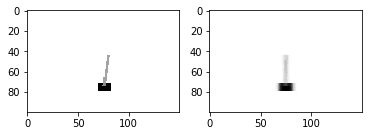

In [18]:
plot_comparison(100)

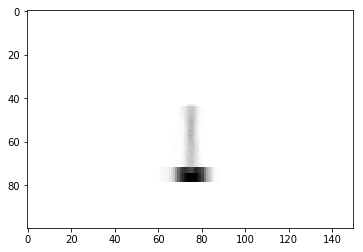

In [22]:
ex = torch.from_numpy(np.array([1, 0, 0.5, 1])).type(torch.FloatTensor)

recon_img = model.decode(ex)
recon_img = recon_img.view(-1, 100, 150, 1).detach().data.numpy()
plt.imshow(np.squeeze(recon_img), cmap=plt.get_cmap('gray'))